In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('dailymilk_production.csv', index_col='Date',parse_dates=True)
df.index.freq = 'D'

In [20]:
df.head()

,Consumption
Date,
2021-01-01,1752
2021-01-02,1094
2021-01-03,1173
2021-01-04,2183
2021-01-05,1949


In [5]:
type(df['Consumption'])

pandas.core.series.Series

<AxesSubplot:xlabel='Date'>

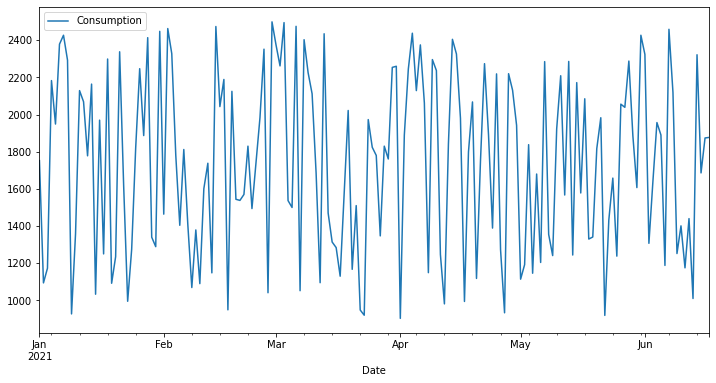

In [10]:
df.plot(figsize=(12,6))

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

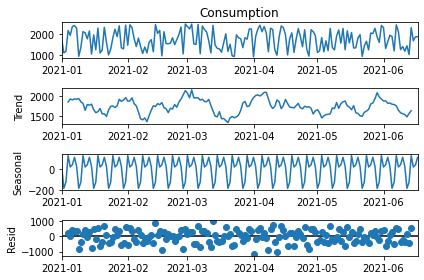

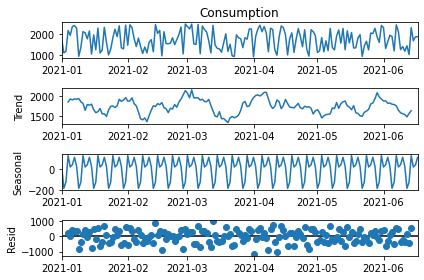

In [13]:
results = seasonal_decompose(df['Consumption'])
results.plot()

In [14]:
len(df)

168

In [13]:
train = df.iloc[:156]
test = df.iloc[156:]

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
df.head(), df.tail()

(            Consumption
 Date                   
 2021-01-01         1752
 2021-01-02         1094
 2021-01-03         1173
 2021-01-04         2183
 2021-01-05         1949,
             Consumption
 Date                   
 2021-06-13         1010
 2021-06-14         2322
 2021-06-15         1686
 2021-06-16         1874
 2021-06-17         1877)

In [15]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
scaled_train[:10]

array([[0.53195489],
       [0.11967419],
       [0.16917293],
       [0.80200501],
       [0.65538847],
       [0.92481203],
       [0.95488722],
       [0.87092732],
       [0.01503759],
       [0.28508772]])

In [17]:
scaled_train.shape

(156, 1)

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
#define generator
n_input = 10
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length =n_input,batch_size=1)

In [22]:
X,y = generator[1]
print(f'Given the Array:  \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array:  
[0.11967419 0.16917293 0.80200501 0.65538847 0.92481203 0.95488722
 0.87092732 0.01503759 0.28508772 0.76817043]
Predict this y: 
 [[0.73057644]]


In [23]:
X.shape

(1, 10, 1)

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [5]:
import tensorflow as tf

In [7]:
tf.config.experimental.list_physical_devices()


True

In [8]:
tf.test.is_built_with_cuda()

True

In [22]:
model = Sequential()
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(100,input_shape=(n_input,n_features)))
##model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 100)               41200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(generator,epochs=120)

Epoch 1/120


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_3/cu_dnnlstm_1/CudnnRNNV2}} with these attrs: [dropout=0, seed=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[sequential_3/cu_dnnlstm_1/CudnnRNNV2]] [Op:__inference_train_function_2865]

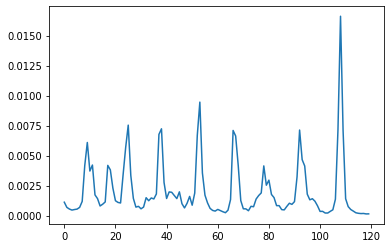

In [50]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [51]:
last_train_batch = scaled_train[-10:]



In [52]:
last_train_batch = last_train_batch.reshape((1,n_input,n_features))

In [53]:
model.predict(last_train_batch)

array([[0.2145415]], dtype=float32)

In [54]:
scaled_test[0]

array([0.17857143])

In [55]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]],axis=1)
    

In [56]:
test_predictions

[array([0.2145415], dtype=float32),
 array([0.29367694], dtype=float32),
 array([0.24318522], dtype=float32),
 array([0.30243808], dtype=float32),
 array([0.36803937], dtype=float32),
 array([0.05557257], dtype=float32),
 array([0.40883318], dtype=float32),
 array([0.32369417], dtype=float32),
 array([0.3529359], dtype=float32),
 array([0.61022943], dtype=float32),
 array([0.8293629], dtype=float32),
 array([0.9911873], dtype=float32)]

In [ ]:
test.head()

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_14712/392929216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

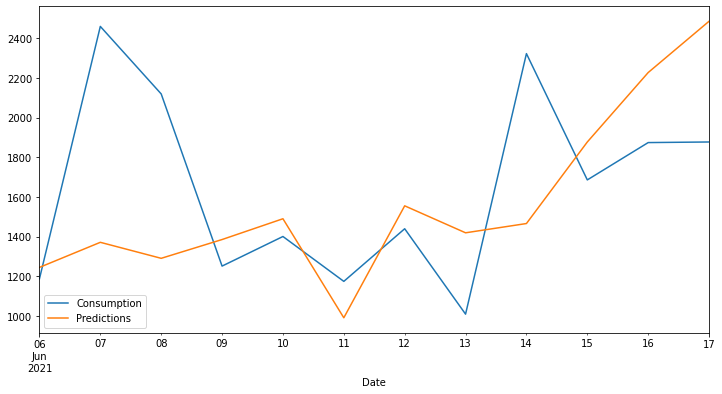

In [57]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,6))